# Домашнее задание

Настроить параметры для новой картинки *data/imgs/ball2.png* на всех 8 методах детекта мяча. 
- [X] Ball detection by MatchTemplate. 1 балл
- [X] Ball detection by HoughCircles. 1 балл
- [X] Ball detection by Canny -> FindContours -> Circularity check. 1 балл
- [X] Ball detection by MSER -> ConvexHull -> MinEnclosingCircle area ratio check. 1 балл
- [X] Ball detection by adaptiveThreshold -> Skeletonize -> Ransac. 1 балл
- [X] Ball detection by large kernel adaptiveTreshold -> findContours -> fitEllipse. 1 балл
- [X] Ball detection by GreenFilter -> DistanceTransform -> ConnectedComponents. 1 балл
- [X] Ball detection by OpenCV built-in SimpleBlobDetector after green filter. 1 балл
- [ ] Придумать свой способ детектирования мяча, способный работать как на картинке *ball.png*, так и на картинке *ball2.png*, без донастройки параметров. 3 балла

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/sPnzE2f4e88rpgsM8 \
Удачи!

# Setup

In [14]:
!git clone -b master https://github.com/StarkitRobots/cvr_course 

Cloning into 'cvr_course'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 65 (delta 17), reused 50 (delta 10), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [24]:
cd cvr_course/notebooks

/content/cvr_course/notebooks


## Setting up matplotlib

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

# Ball detection in 8 ways

## Ball detection by MatchTemplate
Ball detection by dumbest method - per-pixel comparison by MatchTemplate:
- Target ball radius should be known
- No green filter needed


In [2]:
import cv2
from PIL import Image
import numpy as np;
from random import randrange
from math import pi, fabs, sin, cos
from numpy.linalg import inv
import os

In [3]:
im_rgb = cv2.imread("../data/imgs/ball2.png", cv2.IMREAD_COLOR)

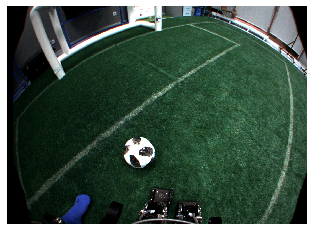

In [4]:
plt.imshow(im_rgb)
plt.axis('off')
plt.show()

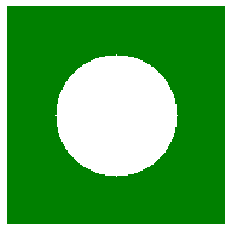

In [14]:
# Target ball radius (known apriori)
radius = 50.0

# Loading input image
im_rgb = cv2.imread("../data/imgs/ball2.png", cv2.IMREAD_COLOR)
im_rgb.astype(np.float32)

# Drawing a synthetic ball image as a template
template = np.zeros( ( int(radius*2.0*1.8), int(radius*2.0*1.8), 3), np.uint8)
# Fill whole template imgage with solig semi-green color
template[:] = (0, 128, 0) 
# Drawing a "ball" - solid white circle 
cv2.circle(template,(int(template.shape[0]/2), int(template.shape[1]/2)), int(radius), (255,255,255),-1)

# Displaying our template
plt.imshow(template)
plt.axis('off')
plt.show()

### Apply template Matching

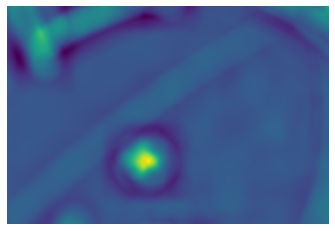

In [15]:
# w,h - size of template
w = template.shape[1]
h = template.shape[0]

# Using built-in OpenCV function MatchTemplate
res = cv2.matchTemplate(im_rgb, template, cv2.TM_CCOEFF)

# Locating global maxima on matchTemplate result - this will be the point of best fit
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = max_loc

# Drawing matchTemplate output image. Darker areas are bad fit, brighter - good fit
plt.imshow(res/max_val)
plt.axis('off')
plt.show()

### Marking found ball with rectangle

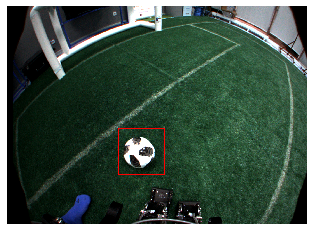

In [16]:
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(im_rgb,top_left, bottom_right, 255, 2)

# Drawing result with marked ball
plt.imshow(im_rgb)
plt.axis('off')
plt.show()

## Ball detection by HoughCircles
- No green filter needed
- Known ball radius used to filter false positives


In [17]:
import cv2
import numpy as np

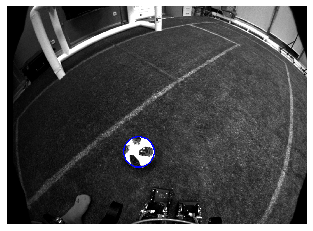

In [18]:
# Target ball radius (known apriori)
radius = 50.0

# Loading input image
im_rgb = cv2.imread("../data/imgs/ball2.png", cv2.IMREAD_COLOR)

# Converting input image to grayscale for HoughCircles to operate on a single-channel image
im = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

# Preparing RGB image from grayscale to draw detection results
im_verbose = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

# Doing HoughCircles, using known ballradius to filter false positives
circles = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, dp=2, minDist=30, param1=300, param2=80, \
                           minRadius=int(radius-10), maxRadius=int(radius+10) )

# Drawing result
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    cv2.circle(im_verbose,(i[0],i[1]),i[2],(0,0,255),4)

plt.imshow(im_verbose)
plt.axis('off')
plt.show()

## Ball detection by Canny -> FindContours -> Circularity check
- No green filter needed


In [19]:
import cv2
import numpy as np;
from random import randrange
from math import pi, fabs

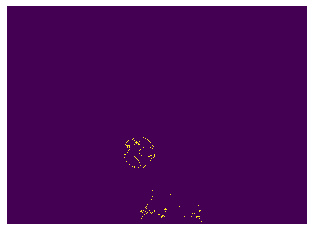

In [20]:
# Preparing input image
im_rgb = cv2.imread("../data/imgs/ball2.png", cv2.IMREAD_COLOR)
im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

# Doing Canny edge detector
edges = cv2.Canny(im_gray, 200, 1000)

# Displaying Canny edge detector results
plt.imshow(edges)
plt.axis('off')
plt.show()

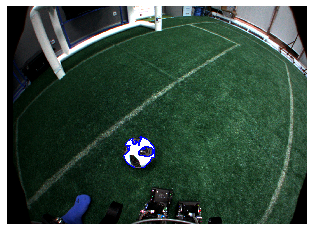

In [21]:
# Doing FindContours to find and separate "contours" - long thin paths of pixels on Canny output
contours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# Checking our contours circularity and drawing result
# Checking each contour
for contour in contours: 
    # Picking some random color to draw a single contour to distinguish them
    color = (randrange(255), randrange(255), randrange(255))     
    # Draw found contour with thin line, this is the contour we wil lcheck and it may or may not be our ball
    cv2.drawContours(im_rgb, contour, -1, color, 1) 
    # Calculating a contour area (assuming it's closed) by built-in function
    area = cv2.contourArea(contour) 
    # Calculating a contour length by built-in function
    perimeter = cv2.arcLength(contour, True)
    # If perimeter is long enough:
    if(perimeter>350):
        #Calculating curculatiry as a ration between area and perimeter. 0 - means bad circularity, 1 - perfect circle
        circularity = 4*pi*area/(perimeter*perimeter)
        if circularity > 0:
            # Drawing a contour of "good" contour with thick red line
            cv2.drawContours(im_rgb, contour, -1, (0,0,255), 3)

# Display detection results
plt.imshow(im_rgb)
plt.axis('off')
plt.show();

## Ball detection by  MSER -> ConvexHull -> MinEnclosingCircle area ratio check 

In [22]:
import cv2
import numpy as np;
from random import randrange
from math import pi, fabs

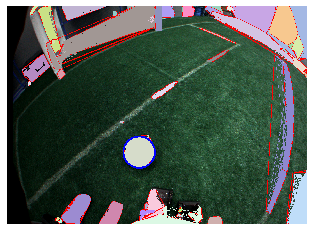

In [23]:
# Preparing input image
im_rgb = cv2.imread("../data/imgs/ball2.png", cv2.IMREAD_COLOR)

# Converting input image to grayscale for MSER to operate on single-channel image
im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

# Doing MSER
# Creating MSER object
mser = cv2.MSER_create()
# Performing MSER calculation, it will return a list of points belonging to each stable region
regions, _ = mser.detectRegions(im_gray)

# Filtering results and picking the best one
best_center = (-1,-1)
best_radius = int(0)
best_area_coeff = 0
# Checking all found regions
for region in regions:
    # Picking some random bright color to draw a single region to distinguish them   
    color = (randrange(128,255), randrange(128,255), randrange(128,255))
    # Calculating convex hull around this region, it will be the region's outer border 
    hull = np.int32([cv2.convexHull(region.reshape(-1, 1, 2))])
    # Drawing each convex hull with blue line
    cv2.polylines(im_rgb, hull, True, (255,0,0), 2)
    # Fill each MSER region with lines of picked random color to demonstrare MSER principle
    cv2.polylines(im_rgb, np.int32([region]), True, color, 1)
    # Calculating convex hull smallest enclosing circle by built-in function    
    (x,y),radius = cv2.minEnclosingCircle(hull[0])
    center = (int(x),int(y))
    # Calculating region area from convex hull
    area_hull = cv2.contourArea(hull[0])
    # Calculating region area from enclosing circle
    area_circle = pi*radius*radius
    # Calculating ration between area from convex hull and area from enclosing circle    
    area_coeff = area_hull/area_circle
    # Picking the region with area best ratio 
    if area_coeff > best_area_coeff:
        best_area_coeff = area_coeff
        best_center = center
        best_radius = int(radius)
# If best region area ratio is close enough to circle
if best_area_coeff > 0.9:
    # Draw this region's minEnclosingCircle as a found ball
    cv2.circle(im_rgb, best_center, best_radius, (0,0,255),5)

# Displaying resulting image
plt.imshow(im_rgb)
plt.axis('off')
plt.show()

## Ball detection by adaptiveThreshold -> Skeletonize -> Ransac
Simple RANSAC circle class refactored from https://github.com/SeongHyunBae/RANSAC-circle-python 

In [24]:
import cv2
import numpy as np;
from random import randrange
from math import pi, fabs, sin, cos
from numpy.linalg import inv

In [25]:
# Target ball radius (known apriori)
radius = 80.0

class SIMPLE_CIRCLE_RANSAC:    
    def __init__(self, x_data, y_data, n):
        self.x_data = x_data
        self.y_data = y_data
        self.n = n
        self.best_inliers = 0
        self.best_model = None

    def random_sampling(self):
        sample = []
        save_ran = []
        count = 0

        # get three points from data
        while True:
            ran = np.random.randint(len(self.x_data))

            if ran not in save_ran:
                sample.append((self.x_data[ran], self.y_data[ran]))
                save_ran.append(ran)
                count += 1

                if count == 3:
                    break

        return sample

    def make_model(self, sample):
        # calculate a circlre from three points

        pt1 = sample[0]
        pt2 = sample[1]
        pt3 = sample[2]

        A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]])
        B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])

        inv_A = inv(A)

        c_x, c_y = np.dot(inv_A, B) / 2
        c_x, c_y = c_x[0], c_y[0]
        r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)

        return c_x, c_y, r

    def eval_model(self, model):
        # Check is this circle is good enough as a ball candidate
        inliers = 0
        c_x, c_y, r = model

        if (r > radius/2-5) and (r < radius/2+5): # checking target radius
            for i in range(len(self.x_data)):
                dis = np.sqrt((self.x_data[i]-c_x)**2 + (self.y_data[i]-c_y)**2)
                if fabs(dis-r) < 3.0:  # hardcoded inliers distance tolerance
                    inliers += 1

        return inliers

    def execute_ransac(self):
        # Performing RANSAC algorythm
        for i in range(self.n):
            try:
                model = self.make_model(self.random_sampling())
            except np.linalg.LinAlgError as err:
                continue

            inliers = self.eval_model(model)

            if inliers > self.best_inliers:
                self.best_model = model
                self.best_inliers = inliers

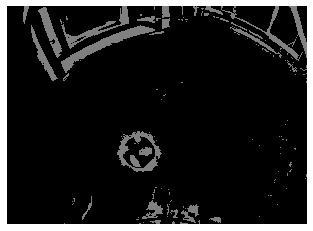

In [26]:
# Loading input image
im_rgb = cv2.imread("../data/imgs/ball2.png", cv2.IMREAD_COLOR)

# Downsizeing the input imgae to speed up computations (python implimentation of RANSAC is reeealy slow)
im_rgb = cv2.pyrDown(im_rgb)

# Converting input image to grayscale
im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

# Doing adaptiveTreshold on grayscale input image to detect regions with big enough local change of a color
im = cv2.adaptiveThreshold(im_gray, 128, cv2.ADAPTIVE_THRESH_MEAN_C,  cv2.THRESH_BINARY_INV, 41, 30)

# Drawing adaptiveTreshold results with gray color
im_verbose = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
plt.imshow(im_verbose)
plt.axis('off')
plt.show()

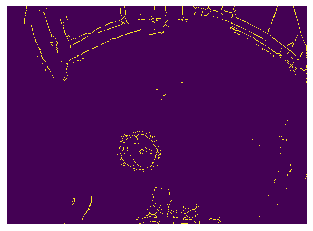

In [27]:
size = np.size(im)
skel = np.zeros(im.shape,np.uint8)
ret,im = cv2.threshold(im,127,255,0)
 
# Set this to 1 to use Zhang-Suen skeletonisation
# This will give better results, but requires opencv-contrib-python package installed by "pip install opencv-contrib-python"
# Set this to 0 if you don't want to install additional packages, 
# processing will be based on barebone OpenCV (slower and worser results but works)

USE_OPENCV_CONTRIB = 0 

# Doing skeletonisation
if USE_OPENCV_CONTRIB:
    # Doing Zhang-Suen skeletonisation (gives better results, but requires opencv-contrib-python package installed)
    skel = cv2.ximgproc.thinning(im)
else:
    # Doing morphological skeletonisation with barebone OpenCV
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False
    while( not done):
        eroded = cv2.erode(im,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(im,temp)
        skel = cv2.bitwise_or(skel,temp)
        im = eroded.copy()

        zeros = size - cv2.countNonZero(im)
        if zeros==size:
            done = True

# Displaying skeletonisation results
plt.imshow(skel)
plt.axis('off')
plt.show()

### Marking pixels of skeletonisation on adaptiveThresold image with green color


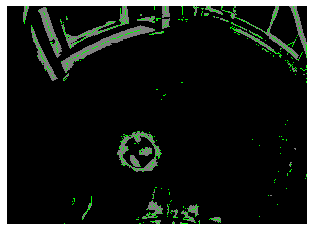

In [28]:
indices = np.where(skel==255)
im_verbose[indices[0], indices[1], :] = [0, 255, 0]
# Displaying skeletonisation on adaptiveThresold image
plt.imshow(im_verbose)
plt.axis('off')
plt.show()

### Performing RANSAC on skeletonised image

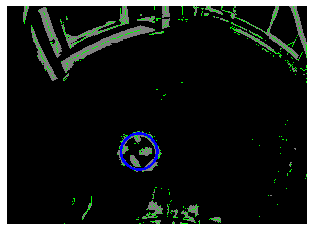

In [29]:
ransac = SIMPLE_CIRCLE_RANSAC( x_data=indices[1], y_data=indices[0], n=50000 )
ransac.execute_ransac()
# Picking RANSAC best fit
a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]
# Drawing RANSAC best fit
cv2.circle(im_verbose, (int(a),int(b)), int(r), (0,0,255),4)

# Displaying resulting image
plt.imshow(im_verbose)
plt.axis('off')
plt.show()

## Ball detection by large kernel adaptiveTreshold -> findContours -> fitEllipse
Known ball radius used for false positives check

In [30]:
import cv2
import numpy as np
from random import randrange
from math import pi, fabs, sin, cos
from numpy.linalg import inv

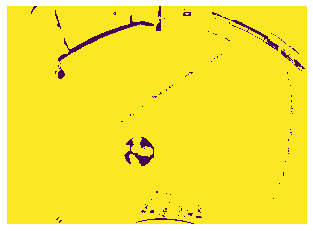

In [31]:
#target ball radius
radius = 50

# Loading input image
im_rgb = cv2.imread("../data/imgs/ball2.png", cv2.IMREAD_COLOR)

# Downsizeing the input image to speed up computations
im_rgb = cv2.pyrDown(im_rgb)

# Converting input image to grayscale
im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

# Doing large kernel adaptive treshold - this will detect the whole ball because it's brighter that it's neighborhood
im = cv2.adaptiveThreshold(im_gray, 128, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  cv2.THRESH_BINARY_INV, 61, -70)

# Displaying adaptiveTreshold results (compare it with previous notebook adaptiveTreshold usage!)
plt.imshow(im)
plt.axis('off')
plt.show()

### Preparing an RGB image to draw tedected contours

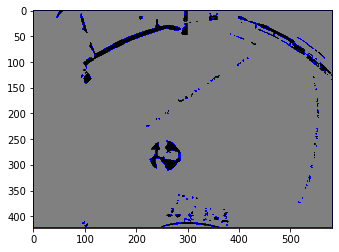

In [32]:

im_contours = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
im_verbose = im_rgb.copy()

# Doing findCountours as before
contours, _ = cv2.findContours(im, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Displaying findContours results
cv2.drawContours(im_contours, contours, -1, (0,0,255), 1)
plt.imshow(im_contours)
plt.show()

### Fitting ellipses for contours and checking their sizes. Correct ellipses will be drawn by red color


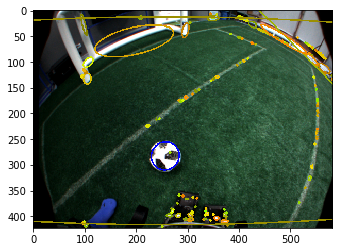

In [33]:
# Check each contour
for contour in contours:
    # Ellipse can be fitted only by 5 points, not less
    if len(contour)>=5:
        # Fitting an ellipse by input points set by built-in OpenCV function (will do it be Least Squares fit)
        el = cv2.fitEllipse(contour)    
        # Picking some non-red random color to draw all fitted ellipses
        color = (randrange(128,255), randrange(128,255), 0)
        w = el[1][0];
        h = el[1][1]
        # If ellipse size (by it's bounding rect) is close to ball size - draw it by thick red circle
        if w > radius-10 and h > radius-10 and w < radius+10 and h < radius+10:
            color = (0,0,255)
        cv2.ellipse(im_verbose, el, color, 2)                

# Displaying resulting image       
plt.imshow(im_verbose)
plt.show()

## Ball detection by GreenFilter -> DistanceTransform -> ConnectedComponents
- Green filter used.
- Target ball radius needed.

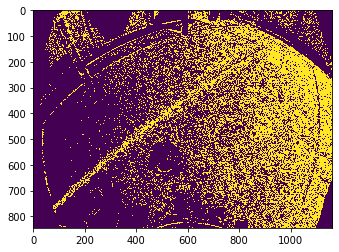

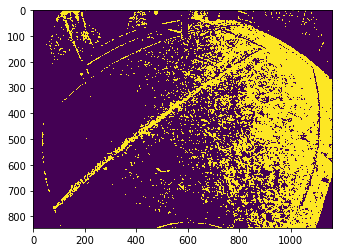

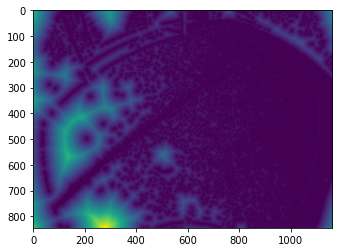

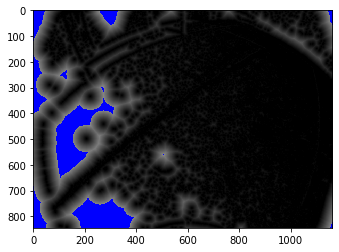

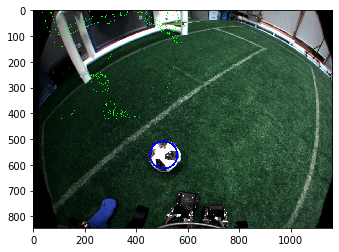

In [34]:
import cv2
import numpy as np;
from random import randrange
from math import pi, fabs, sin, cos
from numpy.linalg import inv

# Loading input image
im_rgb = cv2.imread("../data/imgs/ball2.png", cv2.IMREAD_COLOR)

# Converting input image to grayscale
im_gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

#target ball radius
radius = 75

# Doing simple green filter in HSV
# Converting input image to HSV color space
im_hsv = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2HSV)
# Preparing HSV thresolds
hsv_min = np.array((20, 10, 35), np.uint8)
hsv_max = np.array((60, 125, 190), np.uint8)
# Doing filtration by picked thresholds
im = cv2.inRange(im_hsv, hsv_min, hsv_max)

# Displaying green filter results
plt.imshow(im)
plt.show()


# Filtering speckle noise (false single pixels) by medial filter 
# this is not optimal for black and white image, for demonstration purposes only
im = cv2.medianBlur(im, 5)

# Displaying medial filter results
plt.imshow(im)
plt.show()


# Preparing image to display filtering results
green_verbose = im_rgb.copy()

# Inverting green filter results (we need white objects on black background for distanceTtransform to perform correctly
im_not = cv2.bitwise_not(im)

# Doing distance transform
dist_transform = cv2.distanceTransform(im_not, cv2.DIST_L2, 5) 

# Displaying distance transform results
plt.imshow(dist_transform/100) # Normalise distance transform results by hardcoded 100 value
plt.show()

# Preparing dist_candidates as a floating-point image here with pixel intensity [0..1] for further processing
dist_candidates = cv2.cvtColor(dist_transform/100, cv2.COLOR_GRAY2BGR) 

# Thresholding DistanceTransform by radius, here we will use all points with distance transform result
# bigger than 80% of ball radius as good candidates
ret, candidates = cv2.threshold(dist_transform, radius*0.7, 255,0)
candidates = np.uint8(candidates)

# Marking candidates on verbose image as red color
indices_c = np.where(candidates==255)
dist_candidates[indices_c[0], indices_c[1], :] = [0, 0, 1]

# Displaying candidates
plt.imshow(dist_candidates)
plt.show()

# Extracting candidates centers by connectedComponents
count, markers = cv2.connectedComponents(candidates)

# Checking each candidate pixel cluster
for i in range(count) :
    # blob wil lbe our connected pixels cluster
    blob = np.where(markers==i)
    # calculating blob area by simply count it's size in pixels
    blob_area = len(blob[0])
    # We want to keep only blobs smal lenough to be the ball center after distanceTransform
    allowed_blob_radius = radius*0.05
    # calculating threshold for blob area
    allowed_blob_area = pi * allowed_blob_radius * allowed_blob_radius
       
    # If blob is small enough to be the bal center
    if blob_area < allowed_blob_area:
        # We need to extract exact center of distance transform blob (this will be the "exact" ball center)
        # To do it we need to ckech each pixel of this blob adt pick the biggest one
        # First let's generate a mask - an image on wich only thepixels of this distance transform blob is not zero
        blob_mask = np.zeros( (dist_transform.shape[0], dist_transform.shape[1], 1), np.uint8)        
        blob_mask[blob[0], blob[1]] = 255        
        # now fing a global maxima on whole distance transform image, checking only pixels from this mask
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(dist_transform, mask=blob_mask)
        # Drawing a circle with cenetr in detected maximum and appropriate radious, it will bne our detected ball
        cv2.circle(im_rgb,max_loc,int(max_val),(0,0,255),5)

# marking the green filter output on result image with solif green color for better visibility
im_rgb[indices[0], indices[1], :] = [0, 255, 0]

# Drawing the result
plt.imshow(im_rgb)
plt.show()


## Ball detection by OpenCV built-in SimpleBlobDetector after green filter

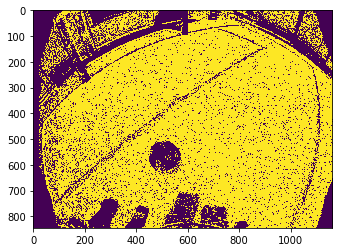

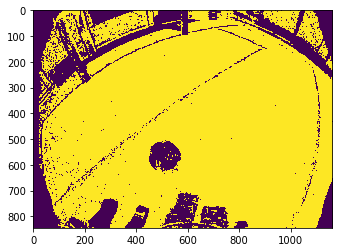

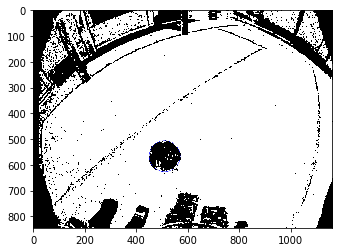

In [35]:
import cv2
import numpy as np;


# Loading input image
im_rgb = cv2.imread("../data/imgs/ball2.png", cv2.IMREAD_COLOR)


# Doing simple green filter in HSV
# Converting input image to HSV color space
im_hsv = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2HSV)
# Preparing HSV thresolds
hsv_min = np.array((10, 10, 10), np.uint8)
hsv_max = np.array((60, 240, 190), np.uint8)
# Doing filtration by picked thresholds
im = cv2.inRange(im_hsv, hsv_min, hsv_max)

# Displaying green filter results
plt.imshow(im)
plt.show()

# Use morphology to remove gaps to make green filter results solid
kernel = np.ones((3,3), np.uint8)
im = cv2.dilate(im, kernel, iterations=1)
im = cv2.erode(im, kernel, iterations=1)
im = cv2.erode(im, kernel, iterations=1)
im = cv2.dilate(im, kernel, iterations=1)
plt.imshow(im)
plt.show()

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 500;

# Filter by Area.
params.filterByArea = True
params.minArea = 5000
params.maxArea = 12000

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

# Create a blob detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else :
    detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs
keypoints = detector.detect(im)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs (will be drawn as thin red circles)
plt.imshow(im_with_keypoints)
plt.show()
